In [1]:
import numpy as np
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nengo
from nengo.utils.ensemble import response_curves
import os
import imageio
%matplotlib inline

In [2]:
def read_image_database(path='faces.npz'):
    images = []
    for file in os.listdir(path):
        images.append(imageio.imread(os.path.join(path,file), as_gray=True))
    mat = np.array(images, dtype=np.uint8)
    return mat
mat = np.load('faces.npz')['arr_0'].astype(np.float64)
def half_resolution(X,rep=1):
    for _ in range(rep):
        r,c = 2*(X.shape[0]//2), 2*(X.shape[1]//2)
        X = 0.25*(X[:r:2, :c:2] + X[1:r:2, 1:c:2] + X[1:r:2, :c:2] + X[:r:2, 1:c:2])
    return X
images_small = []
for i in range(mat.shape[0]):
    images_small.append(half_resolution(mat[i], 2))
mat = np.array(images_small)
X = (2.0 * mat/255.0-1.0)

N = mat.shape[0]
h = mat.shape[1]
w = mat.shape[2]

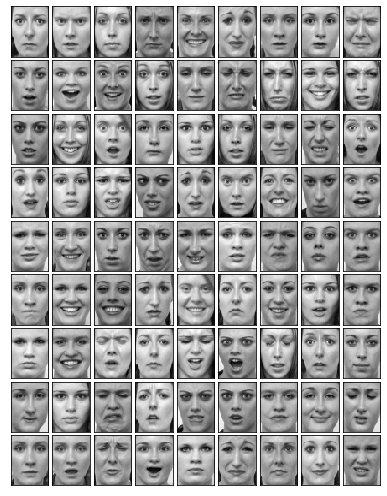

In [3]:
# Plot a picture grid
NN = int(np.floor(np.sqrt(N)))
cmap = cm.get_cmap('gray')
fig, axs = plt.subplots(NN, NN, figsize=(5.5, 7))
for i in range(NN):
    for j in range(NN):
        axs[i, j].imshow(X[NN * i + j].reshape(h, w), vmin=-1, vmax=1, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)

fig.savefig('../face_database.pdf', bbox_inches='tight', transparent=True, dpi=600)

In [4]:
X = X.reshape(N, w*h)
X_zero_mean = X-np.mean(X,axis=0)
X_cov = (X_zero_mean.T @ X_zero_mean)/(X.shape[0]-1)
D,V = np.linalg.eigh(X_cov)
D = D[::-1]
V = V.T[::-1,:]
V = V / np.linalg.norm(V,axis=0)

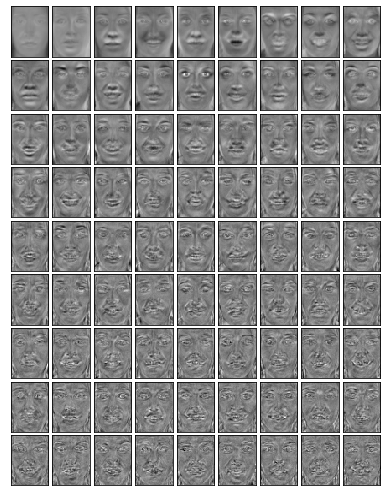

In [5]:
NN = int(np.floor(np.sqrt(N)))
cmap = cm.get_cmap('gray')
fig, axs = plt.subplots(NN, NN, figsize=(5.5, 7))
for i in range(NN):
    for j in range(NN):
        axs[i, j].imshow(V[NN * i + j].reshape(h, w), vmin=-0.125, vmax=0.125, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)

Text(0.5, 1.0, 'zoomed in')

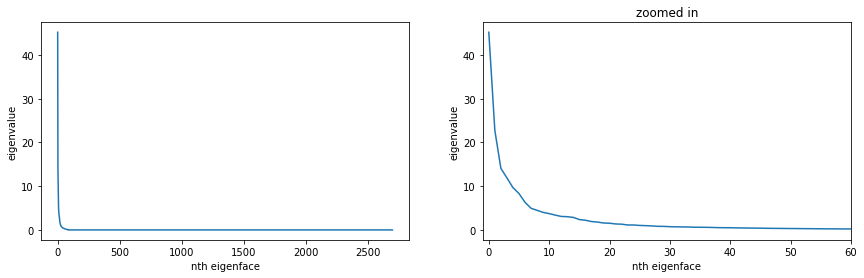

In [6]:
plt.subplot(1,2,1)
plt.plot(D)
plt.xlabel("nth eigenface")
plt.ylabel("eigenvalue")
plt.subplots_adjust(right=2)

plt.subplot(1,2,2)
plt.plot(D)
plt.xlim(-1, 60)
plt.xlabel("nth eigenface")
plt.ylabel("eigenvalue")
plt.title("zoomed in")

###### Since the magnitude of the eigenvalues to the corresponding eigenvectors indicates how important the eigenface is, we can take the first x eigenfaces where the magnitude of its eigenvalue is relatively high. Looking at the zoomed in graph on the right, we see that selecting only the first 20 eigenfaces or even the first 15 will suffice for our Encoders.

In [7]:
def genRandomLinearCombinations(faceList, n):
    from random import sample
    combinations = []
    for _ in range(n):
        numFaces = np.random.randint(1,25)
        coefficients = np.random.randint(-10,10,numFaces)
        indcs = np.random.randint(0, len(faceList)-1, numFaces)
        faces = [faceList[i] for i in indcs]
        combinations.append(sum([c*f for c,f in zip(coefficients,faces)]))
    return np.array(combinations)

In [8]:
numEigenfaces = 15
encoders = V[:numEigenfaces]

In [9]:
# want to keep the same ensemble and see how it represents faces
# if we reinitialze the ensemble for each input, then the curves
# are meaningless 
def Model(X, numNeu, d, E,synap, T, isPlot):
    lenX = len(X)
    populationCurves = []
    representations = []
    sts = []
    model = nengo.Network(seed=581)
    with model:
        ensA = nengo.Ensemble(n_neurons=numNeu,dimensions=d,encoders=E.T,normalize_encoders=False)
    for i in range(len(X)):
        with model:
            inp = nengo.Node(X[i])
            il = nengo.Connection(inp,ensA.neurons)
            inpProbe = nengo.Probe(inp)
            spikes = nengo.Probe(ensA.neurons)
            voltage = nengo.Probe(ensA.neurons, 'voltage')
            filtered = nengo.Probe(ensA,synapse=synap)
        with nengo.Simulator(model, progress_bar=False, optimize=True) as sim:
            if i%10==0: print("running simulation for step:",i)
            sim.run(T)
            # x_axis = 50 x vals
            # y_axis = n_neurons * 50 y values
            responseCurves = response_curves(ensA,sim)
            populationCurves.append(responseCurves)
            representations.append(responseCurves[1])
            sts.append(sim.data[filtered].T)
            if isPlot:
                plt.subplot(12,7,i+1)
                plt.plot(sim.trange(), sim.data[filtered])
    plt.show()
    return populationCurves, representations, sts

In [10]:
def plotImages(X):
    NN = int(np.floor(np.sqrt(len(X))))
    fig,axs = plt.subplots(NN,NN,figsize=(5.5,7))
    for i in range(NN):
        for j in range(NN):
            axs[i,j].imshow(X[NN*i+j].reshape(h,w),cmap='gray')
            axs[i,j].set_xticks([])
            axs[i, j].set_yticks([])
    fig.tight_layout(w_pad=0.0,h_pad=0.0)

## First get neural response for origianl face data

In [12]:
curves1,reps1,st1 = Model(X=X,numNeu=2700,d=15,E=encoders,synap=0.01,T=0.1,isPlot=0)

running simulation for step: 0
running simulation for step: 10
running simulation for step: 20
running simulation for step: 30
running simulation for step: 40
running simulation for step: 50
running simulation for step: 60
running simulation for step: 70
running simulation for step: 80


## Experiment 1: subtract mean face

We run this experiment to see if the neural response of our population will have less overlap, if the original inputs have less overlap. And depending on which output signals are better, we will use them to compare to the rest of our experiments.

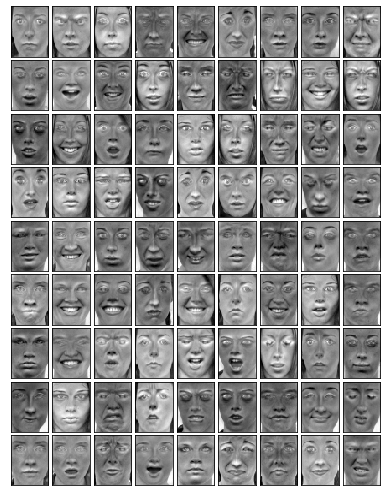

In [11]:
meanFace = np.mean(X,axis=0)
X1 = [x-meanFace for x in X]
plotImages(np.array(X1).reshape(84,60,45))

In [14]:
curvesX1,repsX1,stX1 = Model(X=X1,numNeu=2700,d=15,E=encoders,synap=0.01,T=0.1,isPlot=0)

running simulation for step: 0
running simulation for step: 10
running simulation for step: 20
running simulation for step: 30
running simulation for step: 40
running simulation for step: 50
running simulation for step: 60
running simulation for step: 70
running simulation for step: 80


## Experiment 2: drastically darkening skin colour

Will perform the following by deconstructing each face's PCA weights, and increasing the weight that corresponds to PC2, and reconstructing the face.

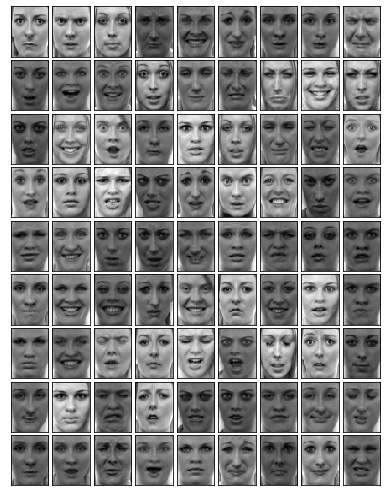

In [12]:
# will darken the skin colour by increasing the intensity of the
# first principal component, which by inspection represnts skin colour.
def changeComponent(change,i, PCs, originalFaces, factor):
    newFaces = []
    for f in originalFaces.reshape(N,h*w):
        newFace = f - factor*PCs[i] if change=="darken" else f +factor*PCs[i]
        newFaces.append(newFace)
    return newFaces
X2 = changeComponent("darken",0,V,X,15)
plotImages(np.array(X2).reshape(N,h,w))

In [33]:
curvesX2,repsX2,stX2 = Model(X=X2,numNeu=2700,d=15,E=encoders,synap=0.01,T=0.1,isPlot=0)

running simulation for step: 0
running simulation for step: 10
running simulation for step: 20
running simulation for step: 30
running simulation for step: 40
running simulation for step: 50
running simulation for step: 60
running simulation for step: 70
running simulation for step: 80


## Experiment 3: drastically brighten skin colour

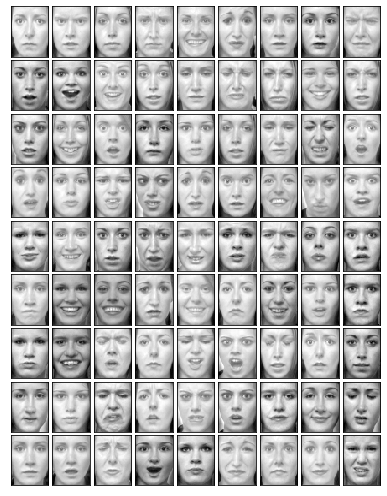

In [34]:
X3 = changeComponent("brighten",0,V,X,15)
plotImages(np.array(X3).reshape(N,h,w))

In [36]:
curvesX3,repsX3,stX3 = Model(X=X3,numNeu=2700,d=15,E=encoders,synap=0.01,T=0.1,isPlot=0)

running simulation for step: 0
running simulation for step: 10
running simulation for step: 20
running simulation for step: 30
running simulation for step: 40
running simulation for step: 50
running simulation for step: 60
running simulation for step: 70
running simulation for step: 80


## Experiment 4: remove eyes

# Analysis

In [38]:
# take signal and average spike activity for each neuron for each face
def spikeAve(spikeData):
    neuronSpikeAves = []
    for spikeTrains in spikeData:
        aves = []
        for st in spikeTrains:
            aves.append(np.mean(st))
        neuronSpikeAves.append(aves)
    return neuronSpikeAves

In [59]:
#find average difference of neuron signals from before and after morphing the faces
def getDiff(aves1,aves2):
    diffs = []
    for a1,a2 in zip(aves1,aves2):
        diff = []
        for x,y in zip(a1,a2):
            diff.append(x-y)
        diffs.append(diff)
    return np.transpose(diffs)

In [61]:
changes = getDiff(spikeAve(st1),spikeAve(stX3))
D,N = np.shape(changes)
sumChanges = []
for d in range(D):
    sumChange = 0
    for n in range(N):
        sumChange += changes[d][n]
    sumChanges.append(sumChange)

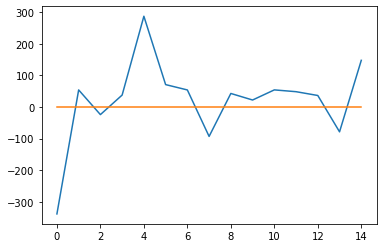

In [66]:
plt.plot(sumChanges)
plt.plot(np.zeros(15))

Note that in this small experiment, there are some neurons which have a larger average response change after removing 10 dimensions out of the original face. The range of neural response change for some neurons after morphing the original face is within 0.1 whereas for others its almost 1.0. This shows that there are neurons which encode for certain regions of the face and changes to other portions of the face are not reflected in the specific neuron's activity.